In [57]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda
import uproot
from tabulate import tabulate

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
#      ".Pe2e2h.eR.pL.n000.d_dstm_15090_2.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

## Big Picture 

In [35]:
pfos = events.MCParticlesSkimmed.matched_pfos.compute()
num_pfos_linked = ak.fill_none(ak.num(pfos.p,axis=2),0)

Text(0.5, 0, 'number of pfos linked to a mc particle')

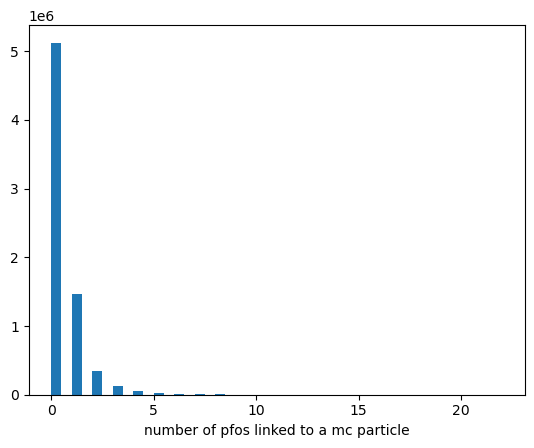

In [36]:
plt.close(1);plt.figure(1)

mini = 0
maxi = np.max(num_pfos_linked)
# maxi = 4 

nbins = 2*(maxi - mini)

plt.hist(ak.flatten(num_pfos_linked),
         bins=nbins,
         range=(mini,maxi))

plt.xlabel('number of pfos linked to a mc particle')

In [37]:
gen = events.PandoraPFOs.matched_gen.compute()
num_gen_linked = ak.fill_none(ak.num(gen.p,axis=2),0)

Text(0.5, 0, 'number of mc particles linked to a pfo')

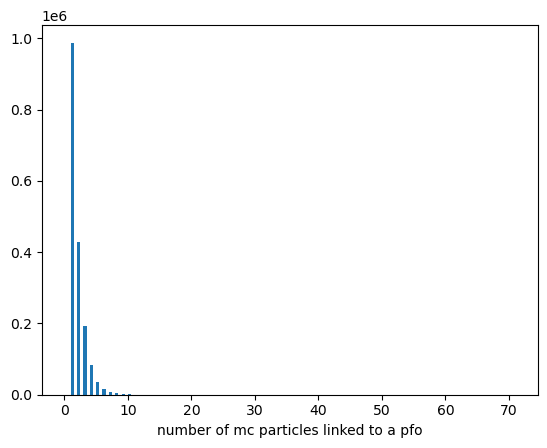

In [40]:
plt.close(1);plt.figure(1)

mini = 0
maxi = np.max(num_gen_linked)
# maxi = 10

nbins = 2*(maxi - mini)

plt.hist(ak.flatten(num_gen_linked),
         bins=nbins,
         range=(mini,maxi))

plt.xlabel('number of mc particles linked to a pfo')

## Close Up

**From https://github.com/iLCSoft/MarlinReco/blob/master/Analysis/RecoMCTruthLink/include/RecoMCTruthLinker.h**:

This relation is based on the number of hits for tracks, for hits weighted with the SimHit-energy for clusters and calorimeter hits. For tracks and clusters, the weight is the sum of hits from the considered true particle divided by the sum of all hits, for calorimter hits, it's simply the simHit energy of the hit.

For the reconstructed particles, the relation could either be only to the true particle having the largest weight, or to all contributing true particles. In the former case, the pointer (and weight) will concern the true particle creating hits in the tracker, if there are any. Only for track-less seen particles would it point to the main contributor to the cluster. In the latter case, pointers are set up to all contributing true particles, and the weight is given as (fractional contribution to track) + 10000* (fractional contribution to cluster), with fractions given in permil (int). Hence: trackwgt = (int(wgt)%10000)/1000. and  clusterwgt = (int(wgt)/10000)/1000. Which of the two is used is selected by the processor flag "FullRecoRelation" (default=true).

For example a weight of 0.95 for a charged particle link implies that 95 percent of the SimTrackerHits used in the particles' track fit have been caused by the linked MCParticle. If a neutral particle with one cluster has no MC contribution assigned the MCParticle pointing closest to the cluster is assigned and the weight is set to the negative scalar product of the MCParticle's momentum direction and the direction to the Cluster position. (This fixes a bug in the Mokka LCal driver ov mokka-v06-06-p03).

A skimmed MCParticle subset collection is created. It containes all particles created by the generator program and all particles that have been reconstructed including all their parents. Additionally, the daughters of all decays in flight of particles specified in 'KeepDaughtersPDG' (default: gamma, K0s and pi0) are kept in the skimmed list if the original particle is in the skim ( either from the generator or from  reconstruction).

In [179]:
reco_index = events.RecoMCTruthLink.reco_index.compute()
mc_index = events.RecoMCTruthLink.mc_index.compute()

mcreco_weights = (events.RecoMCTruthLink.weight_mc_reco.compute())
recomc_weights = (events.RecoMCTruthLink.weight_reco_mc.compute())

mc_p = events.MCParticlesSkimmed.p.compute()
reco_p = events.PandoraPFOs.p.compute()

mc_pdg = events.MCParticlesSkimmed.pdgId.compute()
reco_pdg = events.PandoraPFOs.pdgId.compute()

In [167]:
event=1

arrx = np.array([
                 reco_index[event][ak.argsort(reco_index,axis=1)[event]],
                 reco_p[event][reco_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 mc_p[event][mc_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 recomc_weights[event][ak.argsort(reco_index,axis=1)[event]],
                 mcreco_weights[event][ak.argsort(reco_index,axis=1)[event]],
                 reco_pdg[event][reco_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 mc_pdg[event][mc_index[event]][ak.argsort(reco_index,axis=1)[event]]])

title_arr = np.array(['reco momentum',
                      'mc momentum',
                      'reco->mc weight',
                      'mc->reco weight',
                      'reco pdgId',
                      'mc pdgId'])

table = tabulate(arrx.T, title_arr.T, tablefmt="fancy_grid",floatfmt=('g','g','g','g','g','g'))

print(table)

╒════╤═════════════════╤═══════════════╤═══════════════════╤═══════════════════╤══════════════╤════════════╕
│    │   reco momentum │   mc momentum │   reco->mc weight │   mc->reco weight │   reco pdgId │   mc pdgId │
╞════╪═════════════════╪═══════════════╪═══════════════════╪═══════════════════╪══════════════╪════════════╡
│  0 │        0.254448 │      0.258442 │     1000          │     500           │          211 │        -11 │
├────┼─────────────────┼───────────────┼───────────────────┼───────────────────┼──────────────┼────────────┤
│  1 │        0.182691 │      0.182409 │     1000          │     875           │         -211 │       -211 │
├────┼─────────────────┼───────────────┼───────────────────┼───────────────────┼──────────────┼────────────┤
│  2 │        0.345824 │      0.346603 │        1.0001e+07 │     295           │          211 │        -13 │
├────┼─────────────────┼───────────────┼───────────────────┼───────────────────┼──────────────┼────────────┤
│  3 │        0.369

In [164]:
mc_index[event]

<Array [77, 26, 36, 34, 20, 18] type='6 * int32[parameters={"__doc__": "ind...'>

In [163]:
reco_p[event][reco_index[event]]

<Array [0.254, 0.183, 0.346, 0.37, 34.8, 73.8] type='6 * float32'>

In [236]:
event=0

arrx = np.array([
                 reco_index[event][ak.argsort(reco_index,axis=1)[event]],
                 mc_index[event][ak.argsort(reco_index,axis=1)[event]],
                 reco_p[event][reco_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 mc_p[event][mc_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 (np.floor(recomc_weights[event]%10000)/1000)[ak.argsort(reco_index,axis=1)[event]],
                 (np.floor(recomc_weights[event]/10000)/1000)[ak.argsort(reco_index,axis=1)[event]],
#                  (np.floor(mcreco_weights[event]%10000)/1000)[ak.argsort(reco_index,axis=1)[event]],
#                  (np.floor(mcreco_weights[event]/10000)/1000)[ak.argsort(reco_index,axis=1)[event]],
                 reco_pdg[event][reco_index[event]][ak.argsort(reco_index,axis=1)[event]],
                 mc_pdg[event][mc_index[event]][ak.argsort(reco_index,axis=1)[event]]])

title_arr = np.array(['r momentum',
                      'm momentum',
                      'r trk wgt',
                      'r clst wgt',
#                       'm trk wgt',
#                       'm clst wgt',
                      'r pdgId',
                      'm pdgId'])

table = tabulate(arrx.T, title_arr.T, tablefmt="fancy_grid",floatfmt=('g','g','g','g','g','g'))

print(table)

╒════╤═════╤══════════════╤══════════════╤═════════════╤══════════════╤═══════════╤═══════════╕
│    │     │   r momentum │   m momentum │   r trk wgt │   r clst wgt │   r pdgId │   m pdgId │
╞════╪═════╪══════════════╪══════════════╪═════════════╪══════════════╪═══════════╪═══════════╡
│  0 │  69 │     1.0465   │   1.04784    │       0     │        0.009 │       211 │       211 │
├────┼─────┼──────────────┼──────────────┼─────────────┼──────────────┼───────────┼───────────┤
│  1 │  91 │     0.40131  │   0.401963   │       0     │        1     │      -211 │      -211 │
├────┼─────┼──────────────┼──────────────┼─────────────┼──────────────┼───────────┼───────────┤
│  2 │  67 │     0.84516  │   0.845991   │       0     │        0.02  │      -211 │      -211 │
├────┼─────┼──────────────┼──────────────┼─────────────┼──────────────┼───────────┼───────────┤
│  3 │ 173 │     0.265972 │   0.266181   │       0     │        0.011 │      -211 │      -211 │
├────┼─────┼──────────────┼─────────────

In [254]:
! pdgid 130

K⁰ long
